In [1]:
# Constant Energy molecular dynamics in 6D
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, quad
from matplotlib import animation
from scipy.spatial.distance import pdist,squareform
from scipy.optimize import fmin, fminbound
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')


import tqdm

plt.rc("axes", labelsize = 11)
plt.rc("xtick", labelsize = 10, top = True, direction="in")
plt.rc("ytick", labelsize = 10, right = True, direction="in")
plt.rc("axes", titlesize = 13)
plt.rc("legend", fontsize = 10, loc = "best")
plt.rc('animation', html='jshtml')

In [2]:
class LennardJones:
    def __init__(self, eps0=5, sigma=2**(-1/6)):
        self.eps0 = eps0
        self.sigma = sigma

    def _V(self, r):
        return 4 * self.eps0 * ((self.sigma / r)**12 - (self.sigma / r)**6)

    def _dV_dr(self, r):
        return -4 * self.eps0 * (12 * (self.sigma / r)**12 - 6 * (self.sigma / r)**6) / r

    def potential(self, r):
        return self._V(r)
    
    def force(self, r):
        return -self._dV_dr(r)

class AtomEnsemble():
    def __init__(self, dynamic_positions, velocities, masses, potential = LennardJones, kbT = 10, static_positions = None):
        self.positions = dynamic_positions
        self.velocities = velocities
        self.masses = masses
        self.potential = potential
        self.N_dynamic = len(dynamic_positions)
        self.dim = len(dynamic_positions[0])
        self.kbT = kbT
        if static_positions is not None:
            self.static_positions = static_positions
            self.N_static = len(static_positions)
            self.N = self.N_dynamic + self.N_static
        else:
            self.N = self.N_dynamic
        self.forces = np.zeros((self.N_dynamic, self.dim))
    def compute_forces(self):
        self.forces = np.zeros((self.N_dynamic, self.dim))  # Reset forces
    
        # Forces between dynamic atoms
        for i in range(self.N_dynamic):
            for j in range(i + 1, self.N_dynamic):
                r_vec = self.positions[i] - self.positions[j]
                r = np.linalg.norm(r_vec)
                if r > 1e-8:  # Avoid division by zero or near-zero values
                    f_magnitude = self.potential.force(r)
                    f_vec = f_magnitude * r_vec / r
                    self.forces[i] += f_vec
                    self.forces[j] -= f_vec  # Newton's third law: equal and opposite forces
    
        # Forces from static atoms (if any)
        if hasattr(self, 'static_positions'):
            for i in range(self.N_dynamic):
                for j in range(self.N_static):
                    r_vec = self.positions[i] - self.static_positions[j]
                    r = np.linalg.norm(r_vec)
                    if r > 1e-8:  # Avoid division by zero or near-zero values
                        f_magnitude = self.potential.force(r)
                        f_vec = f_magnitude * r_vec / r
                        self.forces[i] += f_vec
                        # Static atoms are assumed fixed, so their forces aren't updated
    
        return self.forces
    
    def copy(self):
        return AtomEnsemble(self.positions.copy(), self.velocities.copy(), self.masses.copy(), self.potential, self.kbT, self.static_positions.copy())

    def compute_energy(self, positions = None):
        if positions is None:
            positions = self.positions
        energy = 0
        for i in range(self.N_dynamic):
            for j in range(i+1, self.N_dynamic):
                r = np.linalg.norm(positions[i]-positions[j])
                energy += self.potential.potential(r)
        if hasattr(self, 'static_positions'):
            for i in range(self.N_dynamic):
                for j in range(self.N_static):
                    r = np.linalg.norm(positions[i]-self.static_positions[j])
                    energy += self.potential.potential(r)
        return energy
    
    def compute_kinetic_energy(self):
        return 0.5*np.sum(self.masses*np.linalg.norm(self.velocities, axis=1)**2)
    
    def total_energy(self):
        return self.compute_energy() + self.compute_kinetic_energy()
    
    def VV(self, dt = 0.01, steps = 50):
        
        for _ in range(steps):
            force_before = self.compute_forces().copy()
            self.positions += self.velocities*dt + 0.5*force_before*dt**2
            force_after = self.compute_forces().copy()
            self.velocities += 0.5*(force_after + force_before)*dt
        return self.positions, self.velocities
    
    def apply_thermostat(self):
        self.velocities = np.random.normal(0, np.sqrt(self.kbT), (self.N_dynamic, self.dim))
        return self.velocities
    
    def run(self, steps, dt  = 0.01):
        energies = np.zeros(steps)
        positions = [self.positions.copy()]
        for i in range(steps):
            self.apply_thermostat()
            self.VV(dt = dt)
            energies[i] = self.total_energy()
            current_positions = self.positions.copy()
            positions.append(current_positions)
        return energies, positions
    

    def relax_ensemble(self, steps, energy = -2):
        j = 0
        for i in tqdm.tqdm(range(steps)):
            
            old_energy = self.compute_energy()
        
            self.compute_forces()
            self.VV()

            new_energy = self.compute_energy()    
            
            if new_energy > old_energy:
                j +=1

            if self.compute_energy() < energy:# and i > steps/2:
                print(f"Relaxation completed after {i} steps with energy {self.compute_energy()}")
                break

    
    def plot_positions(self, ax):
        ax.scatter(self.positions[:,0], self.positions[:,1], c = 'tab:blue', s = 100)
    
        if hasattr(self, 'static_positions'):
            ax.scatter(self.static_positions[:,0], self.static_positions[:,1], c = 'tab:orange', s = 100) 

        ax.grid(alpha=0.5)

    def plot_statics(self, ax):
        ax.scatter(self.static_positions[:,0], self.static_positions[:,1], c = 'tab:orange', s = 100)

    def __str__(self):
        return f"Ensemble of {self.N} atoms with {self.dim} dimensions"


    



    def line_search(self): 
        forces = self.compute_forces()
        tolerance = 1e-2
        max_iterations = 5000  # Maximum allowed iterations
        iteration = 0

        while np.all(np.linalg.norm(forces, axis=1) > tolerance) and iteration < max_iterations:
            iteration += 1
            #print(f"Iteration {iteration}, Force norms: {np.linalg.norm(forces, axis=1)}")

            # Normalize forces safely
            force_norms = np.linalg.norm(forces, axis=1)
            nonzero_mask = force_norms > 1e-8
            force_direction = np.zeros_like(forces)
            force_direction[nonzero_mask] = forces[nonzero_mask] / force_norms[nonzero_mask, np.newaxis]

            # Line search: find alpha that minimizes energy along the force direction
            def energy_line_search(alpha):
                new_positions = self.positions + alpha * force_direction
                return self.compute_energy(new_positions)

            alpha = fminbound(energy_line_search, -1.0, 1.0)  # Bounded line search
           # print(f"Alpha (step size): {alpha}")

            # Update positions and recompute forces
            self.positions += alpha * force_direction
            forces = self.compute_forces()

        if iteration == max_iterations:
            print("Warning: Line search reached the maximum number of iterations without convergence.")

        return self.positions

    def basin_hopping(self, steps):
        """
        Basin hopping algorithm for global optimization.
        Random perturbations are followed by a local minimization.
        Positions are accepted or rejected based on energy differences.
        """
        for _ in tqdm.tqdm(range(steps)):
            # Store old positions and energy
            old_pos = np.copy(self.positions)
            old_energy = self.compute_energy()
            
            # Apply a random perturbation
            r_random = np.random.normal(0, 0.1, (self.N_dynamic, self.dim))  # Random step
            self.positions += r_random
            
            # Perform local energy minimization (line search)
            self.line_search()
            
            # Compute new energy after minimization
            new_energy = self.compute_energy()
            
            # Metropolis criterion for acceptance
            def p_accept(old_energy, new_energy, T):
                if new_energy < old_energy:
                    return 1.0  # Always accept if energy decreases
                else:
                    return np.exp(-(new_energy - old_energy) / T)  # Probabilistic acceptance
            
            # Check if the step is accepted
            if np.random.rand() < p_accept(old_energy, new_energy, self.kbT):
                # Step accepted, keep new positions
                pass  # No action needed; self.positions are already updated
            else:
                # Step rejected, restore old positions
                self.positions = old_pos
    
        return self.positions


-299.1685166798316


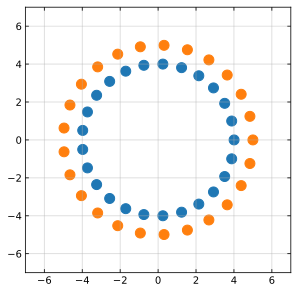

In [3]:
#points in 2d on a circle
def circle_points(n, r):
    return np.array([[r*np.cos(2*np.pi/n*i), r*np.sin(2*np.pi/n*i)] for i in range(n)])


static_positions = circle_points(25, 5)

#random points in 2d inside a circle
dynamic_positions = circle_points(25, 4)
#dynamic_positions += np.random.uniform(-2, 2, dynamic_positions.shape)

fig, ax = plt.subplots()
size = 7

ax.set_xlim(-size, size)
ax.set_ylim(-size, size)

potential = LennardJones()

ensemble = AtomEnsemble(dynamic_positions, np.zeros_like(dynamic_positions), np.ones(25), static_positions = static_positions , potential= potential)


ax.set_aspect('equal')

#ensemble.basin_hopping(20)
ensemble.line_search()
print (ensemble.compute_energy())

ensemble.plot_positions(ax)

fig.savefig('ex28_fig1.png')

100%|██████████| 10/10 [00:52<00:00,  5.21s/it]


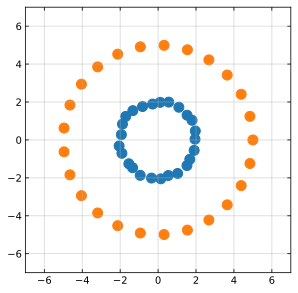

In [4]:
ensemble.compute_energy()
post_relax_positions = ensemble.positions.copy()

static_positions = circle_points(25, 5)

#random points in 2d inside a circle
dynamic_positions = circle_points(25, 2)
dynamic_positions += np.random.uniform(-0.1,0.1, dynamic_positions.shape)

fig, ax = plt.subplots()
size = 7

ax.set_xlim(-size, size)
ax.set_ylim(-size, size)

potential = LennardJones()

ensemble2 = AtomEnsemble(dynamic_positions, np.zeros_like(dynamic_positions), np.ones(20), static_positions = static_positions , potential= potential)

ensemble2.plot_positions(ax)

ax.set_aspect('equal')

ensemble2.basin_hopping(10)

#ensemble2.line_search()

ensemble2.compute_energy()

fig.savefig('ex28_fig2.png')

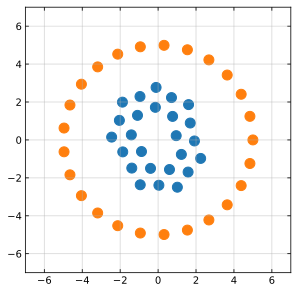

In [5]:
fig, ax = plt.subplots()
size = 7

ax.set_xlim(-size, size)
ax.set_ylim(-size, size)

ensemble2.plot_positions(ax)
ax.set_aspect('equal')



pos1 = post_relax_positions.copy()
pos2 = ensemble2.positions.copy()

fig.savefig('ex28_fig3.png')

In [6]:
kbTs = [.5, 1, 3, 5]


positions_saved = [pos1, pos2]
print(positions_saved)

[array([[ 4.00762993e+00,  1.14993921e-15],
       [ 3.88172287e+00,  9.96657035e-01],
       [ 3.51191288e+00,  1.93069044e+00],
       [ 2.92143649e+00,  2.74341147e+00],
       [ 2.14739550e+00,  3.38375386e+00],
       [ 1.23842576e+00,  3.81148256e+00],
       [ 2.51641165e-01,  3.99972179e+00],
       [-7.50954965e-01,  3.93664379e+00],
       [-1.70636583e+00,  3.62621198e+00],
       [-2.55455946e+00,  3.08793193e+00],
       [-3.24224072e+00,  2.35562577e+00],
       [-3.72620007e+00,  1.47530698e+00],
       [-3.97602857e+00,  5.02289218e-01],
       [-3.97602857e+00, -5.02289218e-01],
       [-3.72620007e+00, -1.47530698e+00],
       [-3.24224072e+00, -2.35562577e+00],
       [-2.55455946e+00, -3.08793193e+00],
       [-1.70636583e+00, -3.62621198e+00],
       [-7.50954965e-01, -3.93664379e+00],
       [ 2.51641165e-01, -3.99972179e+00],
       [ 1.23842576e+00, -3.81148256e+00],
       [ 2.14739550e+00, -3.38375386e+00],
       [ 2.92143649e+00, -2.74341147e+00],
       [ 3

100%|██████████| 4/4 [04:30<00:00, 67.65s/it]


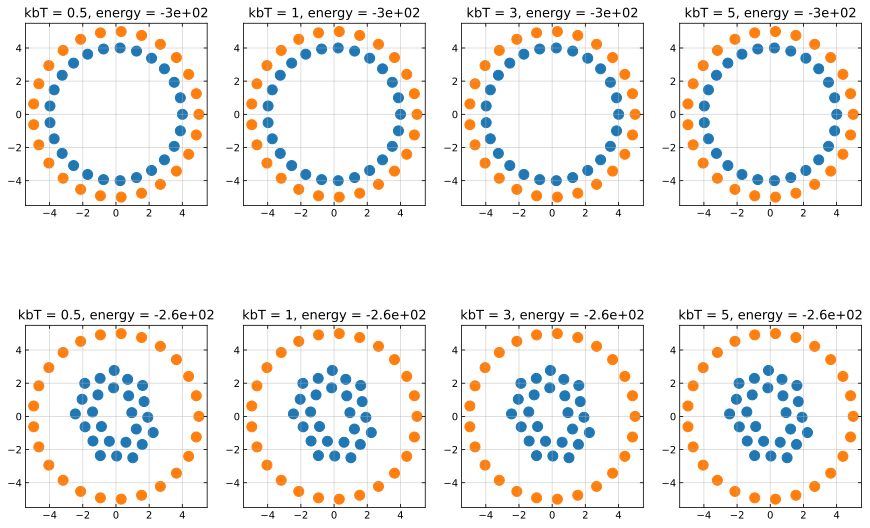

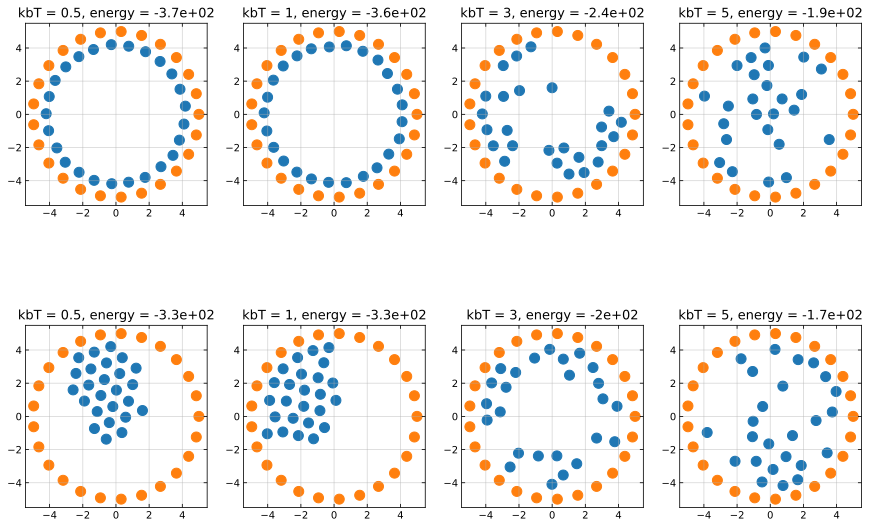

In [7]:
n_sim = 50

#8 ensembles, 4 with each position, each with a different temperature

top_ensembles = []
bottom_ensembles = []


initial_positions = positions_saved.copy()

for kbT in kbTs:
    ensemble_top = AtomEnsemble(initial_positions[0].copy(), np.zeros_like(initial_positions[0]), np.ones(25), static_positions = static_positions , potential= potential, kbT = kbT)
    ensemble_bottom = AtomEnsemble(initial_positions[1].copy(), np.zeros_like(initial_positions[1]), np.ones(25), static_positions = static_positions , potential= potential, kbT = kbT)
     
    top_ensembles.append(ensemble_top)
    bottom_ensembles.append(ensemble_bottom)



top_energy_lists = []
bottom_energy_lists = []

fig, axs = plt.subplots(2, 4, figsize = (15, 10))
for ensemble_sim, ax in zip(top_ensembles, axs[0]):
    ensemble_sim.plot_positions(ax)
    ax.set_aspect('equal')
    ax.set_title(f"kbT = {ensemble_sim.kbT}, energy = {ensemble_sim.compute_energy():.2}")
for ensemble_sim, ax in zip(bottom_ensembles, axs[1]):
    ensemble_sim.plot_positions(ax)
    ax.set_aspect('equal')
    ax.set_title(f"kbT = {ensemble_sim.kbT}, energy = {ensemble_sim.compute_energy():.2}")    


top_pos_lists = []
bottom_pos_lists = []

for i in tqdm.tqdm(range(4)):
    top_energy_list , top_pos_list = top_ensembles[i].run(n_sim)
    bottom_energy_list, bottom_pos_list= bottom_ensembles[i].run(n_sim)

    top_energy_lists.append(top_energy_list)
    bottom_energy_lists.append(bottom_energy_list)
    
    top_pos_lists.append(top_pos_list)
    bottom_pos_lists.append(bottom_pos_list)

fig.savefig('ex28_fig4.png')


fig, axs = plt.subplots(2, 4, figsize = (15, 10))


for ensemble_sim, ax in zip(top_ensembles, axs[0]):
    ensemble_sim.plot_positions(ax)
    ax.set_aspect('equal')
    ax.set_title(f"kbT = {ensemble_sim.kbT}, energy = {ensemble_sim.compute_energy():.2}")

for ensemble_sim, ax in zip(bottom_ensembles, axs[1]):
    ensemble_sim.plot_positions(ax)
    ax.set_aspect('equal')
    ax.set_title(f"kbT = {ensemble_sim.kbT}, energy = {ensemble_sim.compute_energy():.2}")

assert np.allclose(positions_saved, initial_positions), "Positions were overwritten!"

fig.savefig('ex28_fig5.png')

In [8]:

initial_xs_top = [pos[0] for pos in initial_positions[0]]
initial_ys_top = [pos[1] for pos in initial_positions[0]]

initial_xs_bottom = [pos[0] for pos in initial_positions[1]]
initial_ys_bottom = [pos[1] for pos in initial_positions[1]]




MovieWriter imagemagick unavailable; using Pillow instead.


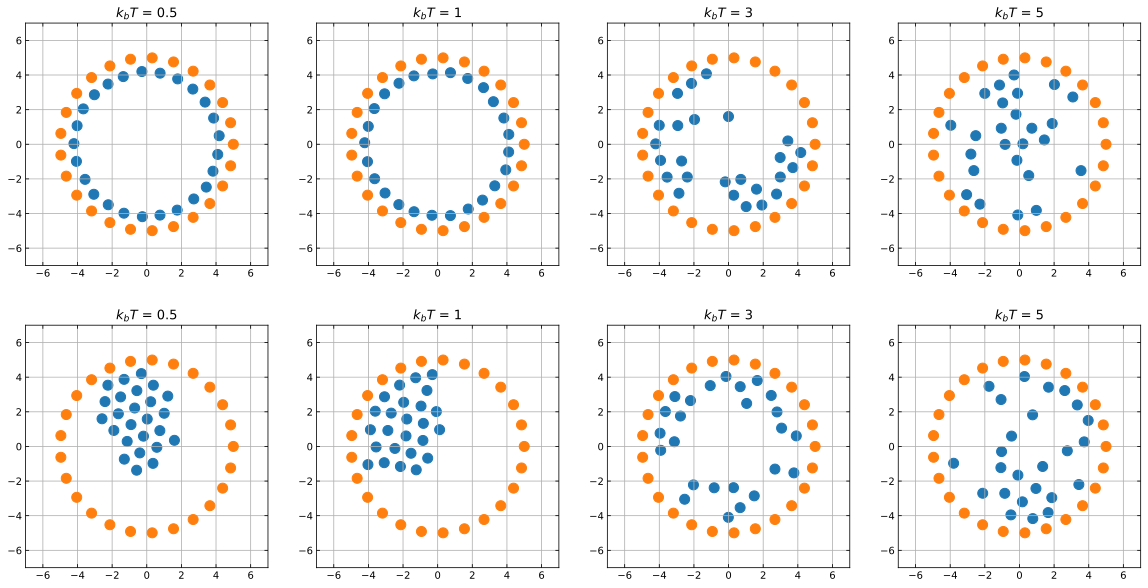

In [15]:
#animation of the position updates

fig, axs = plt.subplots(2,4, figsize = (20, 10))

size = 7

energies = [top_energy_lists, bottom_energy_lists]
# simulation_energies

animated_ensembles = []

#animations for each ensemble both energy and position



animated_ensembles = []
for i, ensemble in enumerate(top_ensembles):
    ax = axs[0][i]

    animated_ensemble = ax.scatter(initial_xs_top, initial_ys_top, c = 'tab:blue', s = 100)
    animated_ensembles.append(animated_ensemble)



for i, ensemble in enumerate(bottom_ensembles):
    initial_position = initial_positions[1]

    animated_ensemble = axs[1][i].scatter(initial_xs_bottom, initial_ys_bottom, c = 'tab:blue', s = 100)
    animated_ensembles.append(animated_ensemble)


for ax, cluster in zip(axs.flatten(), [*top_ensembles, *bottom_ensembles]):
    #plot the static atoms
    ax.grid()
    ax.scatter(static_positions[:,0], static_positions[:,1], c = 'tab:orange', s = 100, zorder = 10)

    ax.set_xlim(-size, size)
    ax.set_ylim(-size, size)
    ax.set_aspect('equal')
    ax.set_title(rf"$k_b T$ = {cluster.kbT}")

poslists = [*top_pos_lists, *bottom_pos_lists]



def animate(i):
    for poslist, ensemble_animated in zip(poslists, animated_ensembles):
        position = poslist[i]
    
        xs_top = [pos[0] for pos in position]
        ys_top = [pos[1] for pos in position]
        
        ensemble_animated.set_offsets(np.c_[xs_top, ys_top])
    
    return animated_ensembles


#raise embedded animation size limit
plt.rcParams['animation.embed_limit'] = 2**128


ani = animation.FuncAnimation(fig, animate, frames=len(poslists[0]), interval=100, blit = True)
ani.save('ex28_animation.gif', writer='imagemagick', fps = 10)




In [11]:
len(top_energy_lists[0])

50

In [12]:
# ani.save("ensemble_animation.gif", writer = 'ffmpeg', fps = 10)

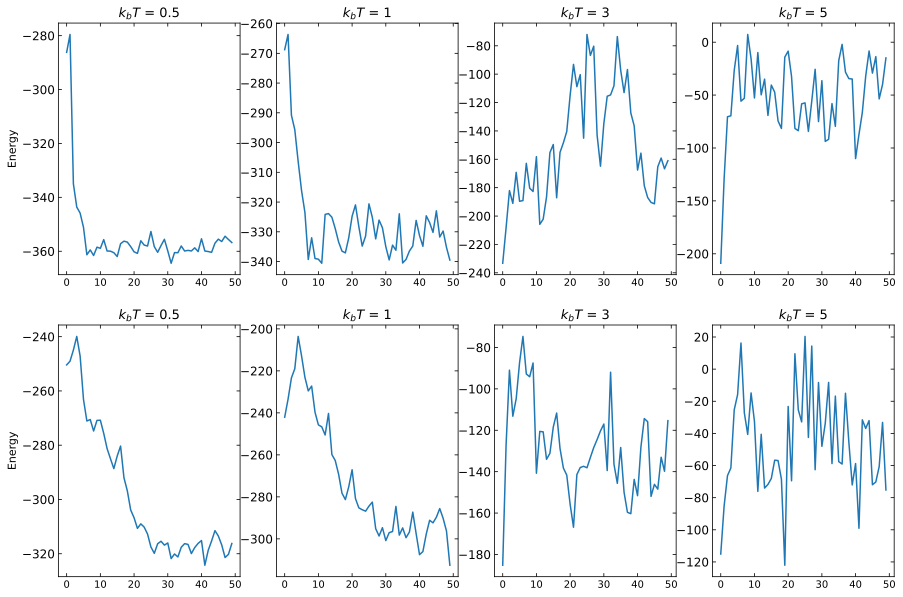

In [13]:
#energy plots
fig, axs = plt.subplots(2, 4, figsize = (15, 10))
for i, (top_energy_list, bottom_energy_list) in enumerate(zip(top_energy_lists, bottom_energy_lists)):
    ax1 = axs[0][i]
    ax2 = axs[1][i]
    ax1.plot(top_energy_list)
    ax2.plot(bottom_energy_list)
    ax1.set_title(f"$k_bT$ = {top_ensembles[i].kbT}")
    ax2.set_title(f"$k_bT$ = {bottom_ensembles[i].kbT}")
    #make y ticks larger
    ax1.tick_params(axis='y', labelsize = 12)
    ax2.tick_params(axis='y', labelsize = 12)
axs[0][0].set_ylabel("Energy")
axs[1][0].set_ylabel("Energy")

fig.savefig('ex28_fig6.png')


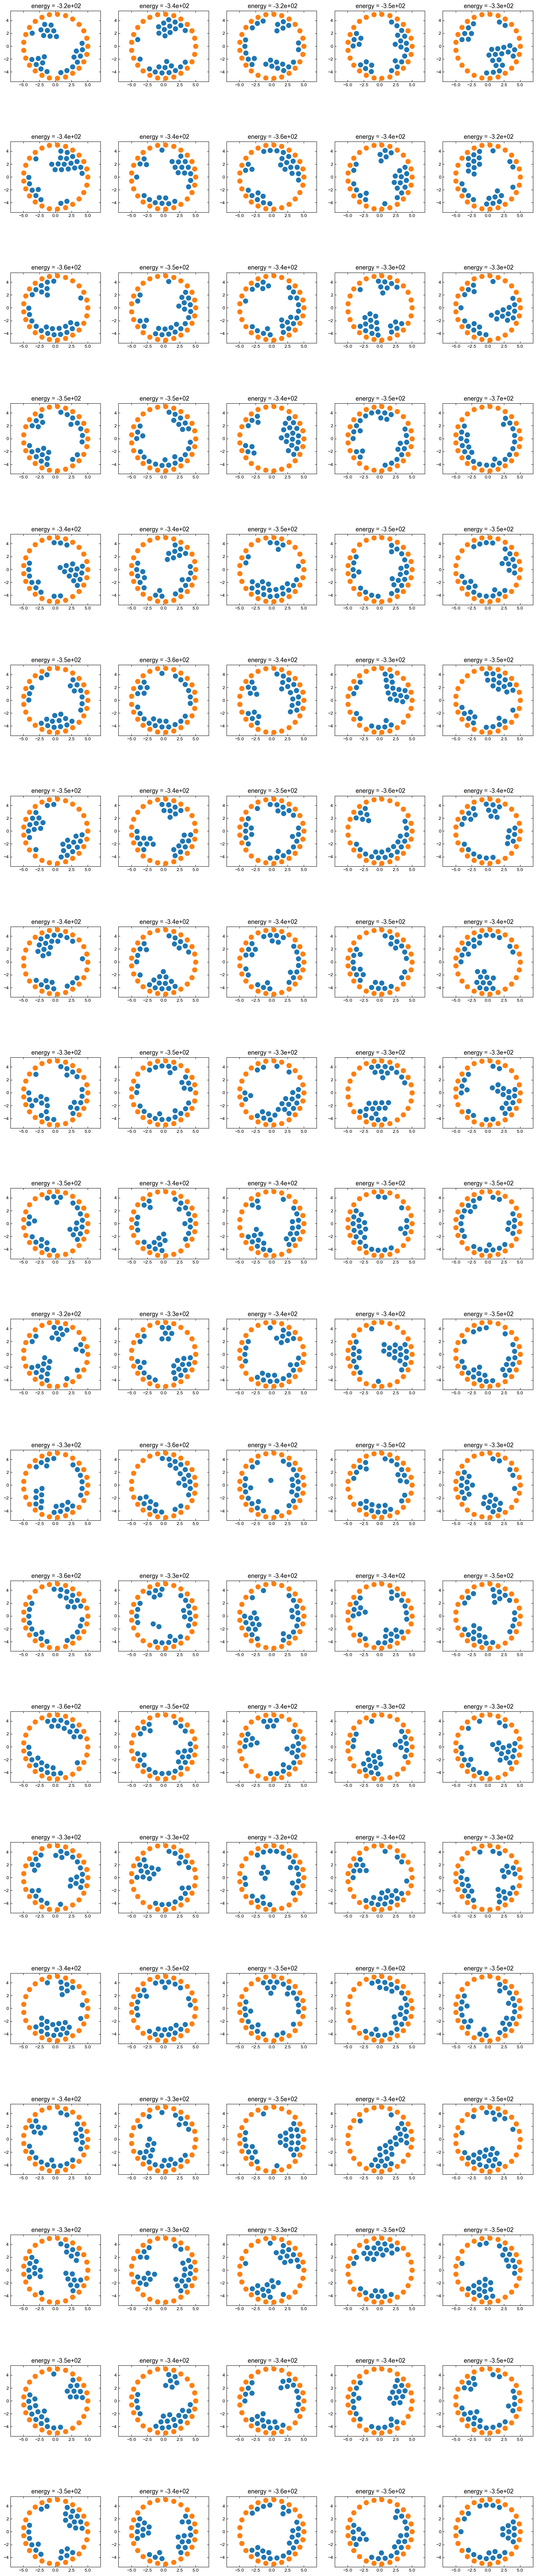

In [14]:
fig, axs = plt.subplots(20,5 , figsize = (20, 100))



for ensemble, ax in zip(Cooled_ensambles, axs.flatten()):
    
    ensemble.plot_positions(ax)
    ax.set_xlim(-size, size)
    ax.set_aspect('equal')
    ax.set_title(f" energy = {ensemble.compute_energy():.2}")

fig.savefig('ex28_fig7.png')

In [23]:
first_energy = chaotic_ensemble.compute_energy()
for ensemble in Cooled_ensambles:

    if ensemble.compute_energy() < first_energy:
        first_energy = ensemble.compute_energy()
        current_ensemble = ensemble.copy()

fig, ax = plt.subplots()
current_ensemble.plot_positions(ax)
ax.set_aspect('equal')
ax.set_title(f" energy = {current_ensemble.compute_energy():.5}")



NameError: name 'chaotic_ensemble' is not defined

In [23]:
#save the annealed ensembles

# np.save("annealed_ensembles.npy", [ensemble.positions for ensemble in Cooled_ensambles])

NameError: name 'current_ensemble' is not defined

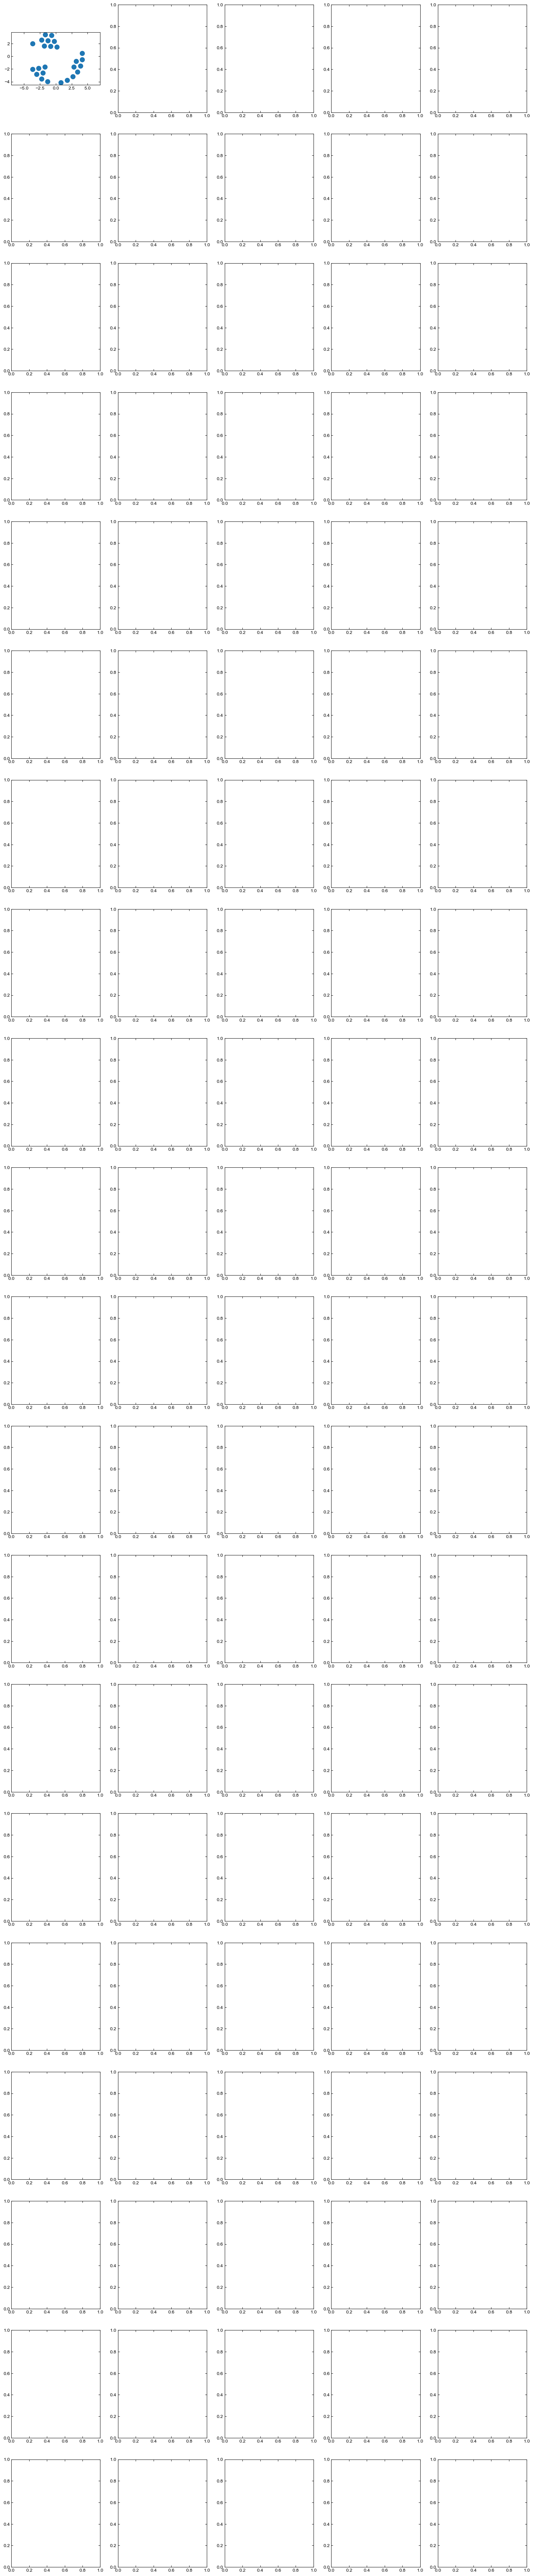

In [22]:
#import and plot the annealed ensembles

annealed_ensembles = np.load("annealed_ensembles.npy", allow_pickle = True)

fig, axs = plt.subplots(20,5 , figsize = (20, 100))

for ensemble, ax in zip(annealed_ensembles, axs.flatten()):
    ax.scatter(ensemble[:,0], ensemble[:,1], c = 'tab:blue', s = 100)
    ax.set_xlim(-size, size)
    ax.set_aspect('equal')
    ax.set_title(f" energy = {current_ensemble.compute_energy():.5}")
    ax.scatter(static_positions[:,0], static_positions[:,1], c = 'tab:orange', s = 100)

In [25]:
#find global minimum
for ensemble in annealed_ensembles:
    if ensemble.compute_energy() < first_energy:
        first_energy = ensemble.compute_energy()
        current_ensemble = ensemble.copy()
        
    

AttributeError: 'numpy.ndarray' object has no attribute 'compute_energy'

In [ ]:
#import and plot the annealed ensembles

annealed_ensembles = np.load("annealed_ensembles.npy", allow_pickle = True)

fig, axs = plt.subplots(20,5 , figsize = (20, 100))

for ensemble, ax in zip(annealed_ensembles, axs.flatten()):
    ax.scatter(ensemble[:,0], ensemble[:,1], c = 'tab:blue', s = 100)
    ax.set_xlim(-size, size)
    ax.set_aspect('equal')
    ax.set_title(f" energy = {current_ensemble.compute_energy():.2}")
    ax.scatter(static_positions[:,0], static_positions[:,1], c = 'tab:orange', s = 100)